In [27]:
import numpy as np
import pandas as pd
import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Data in data_cube

In [28]:
pi_data_dict = {0: "3D",
                1: "VNIR 1",
                2: "VNIR 2",
                3: "VNIR 3",
                4: "VNIR 4",
                5: "VNIR 5",
                6: "VNIR 6",
                7: "VNIR 7",
                8: "VNIR 8",
                9: "XRT 1",
                10: "XRT 2"}

### Creation of a dataset class

In [29]:
class PickItDataset(Dataset):

    def __init__(self, pickle_path, transform=None):
        data = pd.read_pickle(pickle_path)
        self.cube = data["data_cube"]
        self.masks = data["masks"]
        self.labels = data["class"]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            index = index.tolist()

        cube = torch.from_numpy(self.cube[idx].copy())
        mask = self.masks[idx]
        label = self.labels[idx]

        sample = {"cube": cube, "mask": mask, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample


### Definition of the transforms

In [30]:
class Rescale(object):
    def __init__(self, h, w):
        self.h = h
        self.w = w

    def __call__(self, sample):
        cube, mask, label = sample["cube"], sample["mask"], sample["label"]
        cube = transforms.Resize((self.h, self.w))(cube)
        mask = np.resize(mask, (self.h, self.w))
        return {"cube": cube, "mask": mask, "label": label}


class RandomHorizontalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, sample):
        cube, mask, label = sample["cube"], sample["mask"], sample["label"]
        if random.random() < self.p:
            cube = transforms.RandomHorizontalFlip(p=1)(cube)
            mask = np.fliplr(mask)
        return {"cube": cube, "mask": mask.copy(), "label": label}
    
class RandomVerticalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, sample):
        cube, mask, label = sample["cube"], sample["mask"], sample["label"]
        if random.random() < self.p:
            cube = transforms.RandomVerticalFlip(p=1)(cube)
            mask = np.flipud(mask)
        return {"cube": cube, "mask": mask.copy(), "label": label}
    
class Normalize(object):
    def __call__(self, sample):
        cube, mask, label = sample["cube"], sample["mask"], sample["label"]
        mean = cube.mean()
        std = cube.std()
        cube = transforms.Normalize(mean,std)(cube)
        return {"cube": cube, "mask": mask, "label": label}

In [31]:
def plot_sample(sample, layer):
    plt.imshow(sample["cube"][layer])
    plt.colorbar()
    plt.show()

### loadind the dataset, applying the transforms and creating the dataloader

In [32]:
pickle_path = './data/original/dataset_3d_vnir_xrt.pkl'

composed = transforms.Compose([Rescale(256, 256),RandomHorizontalFlip(0.5),RandomVerticalFlip(0.5),Normalize()])
pickit_dataset = PickItDataset(pickle_path, transform=composed)

X_train, X_test, y_train, y_test = train_test_split(pickit_dataset, pickit_dataset.labels, test_size=0.2, random_state=42)
X_train

[{'cube': tensor([[[-0.5314, -0.5314, -0.5314,  ..., -0.5314, -0.5314, -0.5314],
           [-0.5314, -0.5314, -0.5314,  ..., -0.5314, -0.5314, -0.5314],
           [-0.5314, -0.5314, -0.5314,  ..., -0.5314, -0.5314, -0.5314],
           ...,
           [-0.5311, -0.5311, -0.5311,  ..., -0.5314, -0.5314, -0.5314],
           [-0.5311, -0.5311, -0.5311,  ..., -0.5314, -0.5314, -0.5314],
           [-0.5311, -0.5311, -0.5311,  ..., -0.5314, -0.5314, -0.5314]],
  
          [[-0.5314, -0.5314, -0.5314,  ..., -0.5314, -0.5314, -0.5314],
           [-0.5314, -0.5314, -0.5314,  ..., -0.5314, -0.5314, -0.5314],
           [-0.5314, -0.5314, -0.5314,  ..., -0.5314, -0.5314, -0.5314],
           ...,
           [-0.2026, -0.2026, -0.2026,  ..., -0.5314, -0.5314, -0.5314],
           [-0.2026, -0.2026, -0.2026,  ..., -0.5314, -0.5314, -0.5314],
           [-0.2026, -0.2026, -0.2026,  ..., -0.5314, -0.5314, -0.5314]],
  
          [[-0.5314, -0.5314, -0.5314,  ..., -0.5314, -0.5314, -0.5314],
   

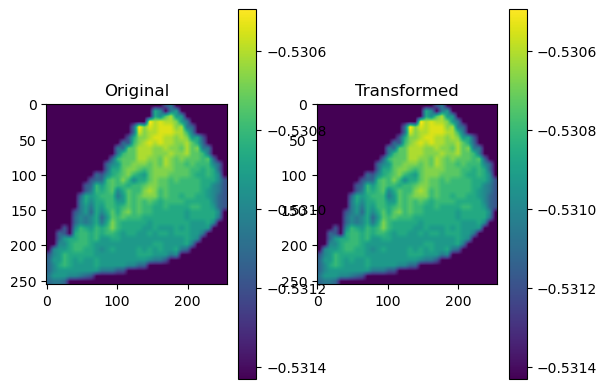

In [33]:
def compare_transformed(sample, transforms, layer):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(sample["cube"][layer])
    ax1.set_title("Original")
    # color bar
    fig.colorbar(ax1.imshow(sample["cube"][layer]), ax=ax1)
    sample = transforms(sample)
    ax2.imshow(sample["cube"][layer])
    ax2.set_title("Transformed")
    fig.colorbar(ax2.imshow(sample["cube"][layer]), ax=ax2)
    plt.show()
    
sample = X_train[0]
compare_transformed(sample, composed, 0)    


In [34]:
# multiply layers 0 and 1:8

def multiply_layers(sample):
    cube, mask, label = sample["cube"], sample["mask"], sample["label"]
    d3_vnir = []
    for i in range(1, 9):
        d3_vnir.append(cube[0] * cube[i])
    d3_vnir = torch.stack(d3_vnir)
    cube = torch.cat((cube, d3_vnir), 0)

    xray_vnir = []
    for i in range(9,11):
        for j in range(1,9):
            xray_vnir.append(cube[i] * cube[j])
    xray_vnir = torch.stack(xray_vnir)
    cube = torch.cat((cube, xray_vnir), 0)

    d3_xray = []
    for i in range(9,11):
        d3_xray.append(cube[0] * cube[i])
    d3_xray = torch.stack(d3_xray)
    cube = torch.cat((cube, d3_xray), 0)
    
    return {"cube": cube, "mask": mask, "label": label}


composed = transforms.Compose([Rescale(256, 256),RandomHorizontalFlip(0.5),RandomVerticalFlip(0.5),Normalize(), multiply_layers])
pickit_dataset = PickItDataset(pickle_path, transform=composed)

X_train, X_test, y_train, y_test = train_test_split(pickit_dataset, pickit_dataset.labels, test_size=0.2, random_state=42)

In [35]:
# print shape of cube
print(X_train[0]["cube"].shape)

torch.Size([37, 256, 256])
